<a href="https://colab.research.google.com/github/Saria-Alashry/Alashry/blob/%D8%A7%D9%84%D9%83%D9%88%D8%B1%D8%B3-%D8%A7%D9%84%D9%85%D9%81%D8%B5%D9%84-%D9%81%D9%8A-%D8%A7%D9%84%D8%B0%D9%83%D8%A7%D8%A1-%D8%A7%D9%84%D8%A7%D8%B5%D8%B7%D9%86%D8%A7%D8%B9%D9%8A-%D9%88%D9%85%D8%B3%D8%A7%D8%A8%D9%82%D8%A9-%D8%A8%D8%B1%D9%85%D8%AC%D8%A9-50-%D8%A7%D9%84%D9%81-%D8%AC%D9%86%D9%8A%D9%87/Week5_Part1_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 Part 1: Data Preprocessing

**Instructor:** Dr. Mahmoud Eid (m.eid@fci-cu.edu.eg)
**Time:** ~2 hours

<div dir="rtl">
<b>النهاردة هنتعلم ازاي نحضر الـ data قبل الـ training بإذن الله!</b>
</div>

## Topics
1. Z-Score Normalization & Cost Surfaces
2. Outlier Detection & Handling
3. Missing Value Imputation Strategies

**Real Datasets:**
- California Housing (20,640 houses)
- Diabetes Dataset (442 patients)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('dark_background')
np.random.seed(42)
print("✅ Ready!")


✅ Ready!


---
# 1. Z-Score Normalization

**Problem:** Features with different scales create elongated cost surfaces

**Solution:** Normalize to mean=0, std=1

$$z = \frac{x - \mu}{\sigma}$$


In [2]:
# Load California Housing dataset
housing = fetch_california_housing()
X_housing = housing.data[:1000]  # Use 1000 samples
y_housing = housing.target[:1000]

print(f"Dataset: California Housing")
print(f"Samples: {len(X_housing)}")
print(f"Features: {X_housing.shape[1]}")
print(f"Feature names: {housing.feature_names}")


Dataset: California Housing
Samples: 1000
Features: 8
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [3]:
# Use two features with VERY different scales
X_unnormalized = X_housing[:, [0, 3]].copy()  # MedInc (0-15) vs AveBedrms (0-50)

print("\n--- Feature Scales BEFORE Normalization ---")
print(f"Feature 0 (MedInc):    min={X_unnormalized[:, 0].min():.2f}, max={X_unnormalized[:, 0].max():.2f}")
print(f"Feature 1 (AveBedrms): min={X_unnormalized[:, 1].min():.2f}, max={X_unnormalized[:, 1].max():.2f}")



--- Feature Scales BEFORE Normalization ---
Feature 0 (MedInc):    min=0.50, max=13.50
Feature 1 (AveBedrms): min=0.57, max=2.70


In [4]:
# Apply StandardScaler .. notice how we can manually call the function to do that quickly or we can do that manually as well you have seen both
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_unnormalized)

print("\n--- Feature Scales AFTER Normalization ---")
print(f"Feature 0: mean={X_normalized[:, 0].mean():.10f}, std={X_normalized[:, 0].std():.6f}")
print(f"Feature 1: mean={X_normalized[:, 1].mean():.10f}, std={X_normalized[:, 1].std():.6f}")



--- Feature Scales AFTER Normalization ---
Feature 0: mean=-0.0000000000, std=1.000000
Feature 1: mean=0.0000000000, std=1.000000


In [5]:
# Gradient descent implementation
def gradient_descent_regression(X, y, learning_rate, epochs=500, tol=1e-6):
    weights = np.zeros(X.shape[1])
    bias = 0
    cost_history = []

    for epoch in range(epochs):
        # Forward pass
        y_pred = X @ weights + bias

        # Compute cost (MSE)
        cost = 1/2*np.mean((y_pred - y) ** 2)
        cost_history.append(cost)

        # Check convergence
        if epoch > 0 and abs(cost_history[-2] - cost_history[-1]) < tol: # notice how here we can check for improvement
            return weights, bias, cost_history, True

        # Backward pass (gradients)
        dw = (1 / len(X)) * X.T @ (y_pred - y)
        db = (1 / len(X)) * np.sum(y_pred - y)

        # Update weights
        weights -= learning_rate * dw
        bias -= learning_rate * db

    return weights, bias, cost_history, False

print("Gradient descent function defined")


Gradient descent function defined


In [6]:
# Train WITHOUT normalization (requires tiny learning rate otherwise the high scale feature will cause the step to move with a huge amount!)
w_unnorm, b_unnorm, cost_unnorm, converged = gradient_descent_regression(
    X_unnormalized, y_housing, learning_rate=1e-7, epochs=500
)

print("\n--- Training WITHOUT Normalization ---")
print(f"Learning rate: 1e-7 (very small due to scale mismatch)")
print(f"Final cost: {cost_unnorm[-1]:.4f}")
print(f"Converged: {converged}")



--- Training WITHOUT Normalization ---
Learning rate: 1e-7 (very small due to scale mismatch)
Final cost: 2.5861
Converged: False


In [7]:
# Train WITH normalization (can use much larger learning rate!)
w_norm, b_norm, cost_norm, converged = gradient_descent_regression(
    X_normalized, y_housing, learning_rate=0.01, epochs=500
)

print("\n--- Training WITH Normalization ---")
print(f"Learning rate: 0.01 (100,000x larger!)")
print(f"Final cost: {cost_norm[-1]:.4f}")
print(f"Converged: {converged}")



--- Training WITH Normalization ---
Learning rate: 0.01 (100,000x larger!)
Final cost: 0.1634
Converged: False


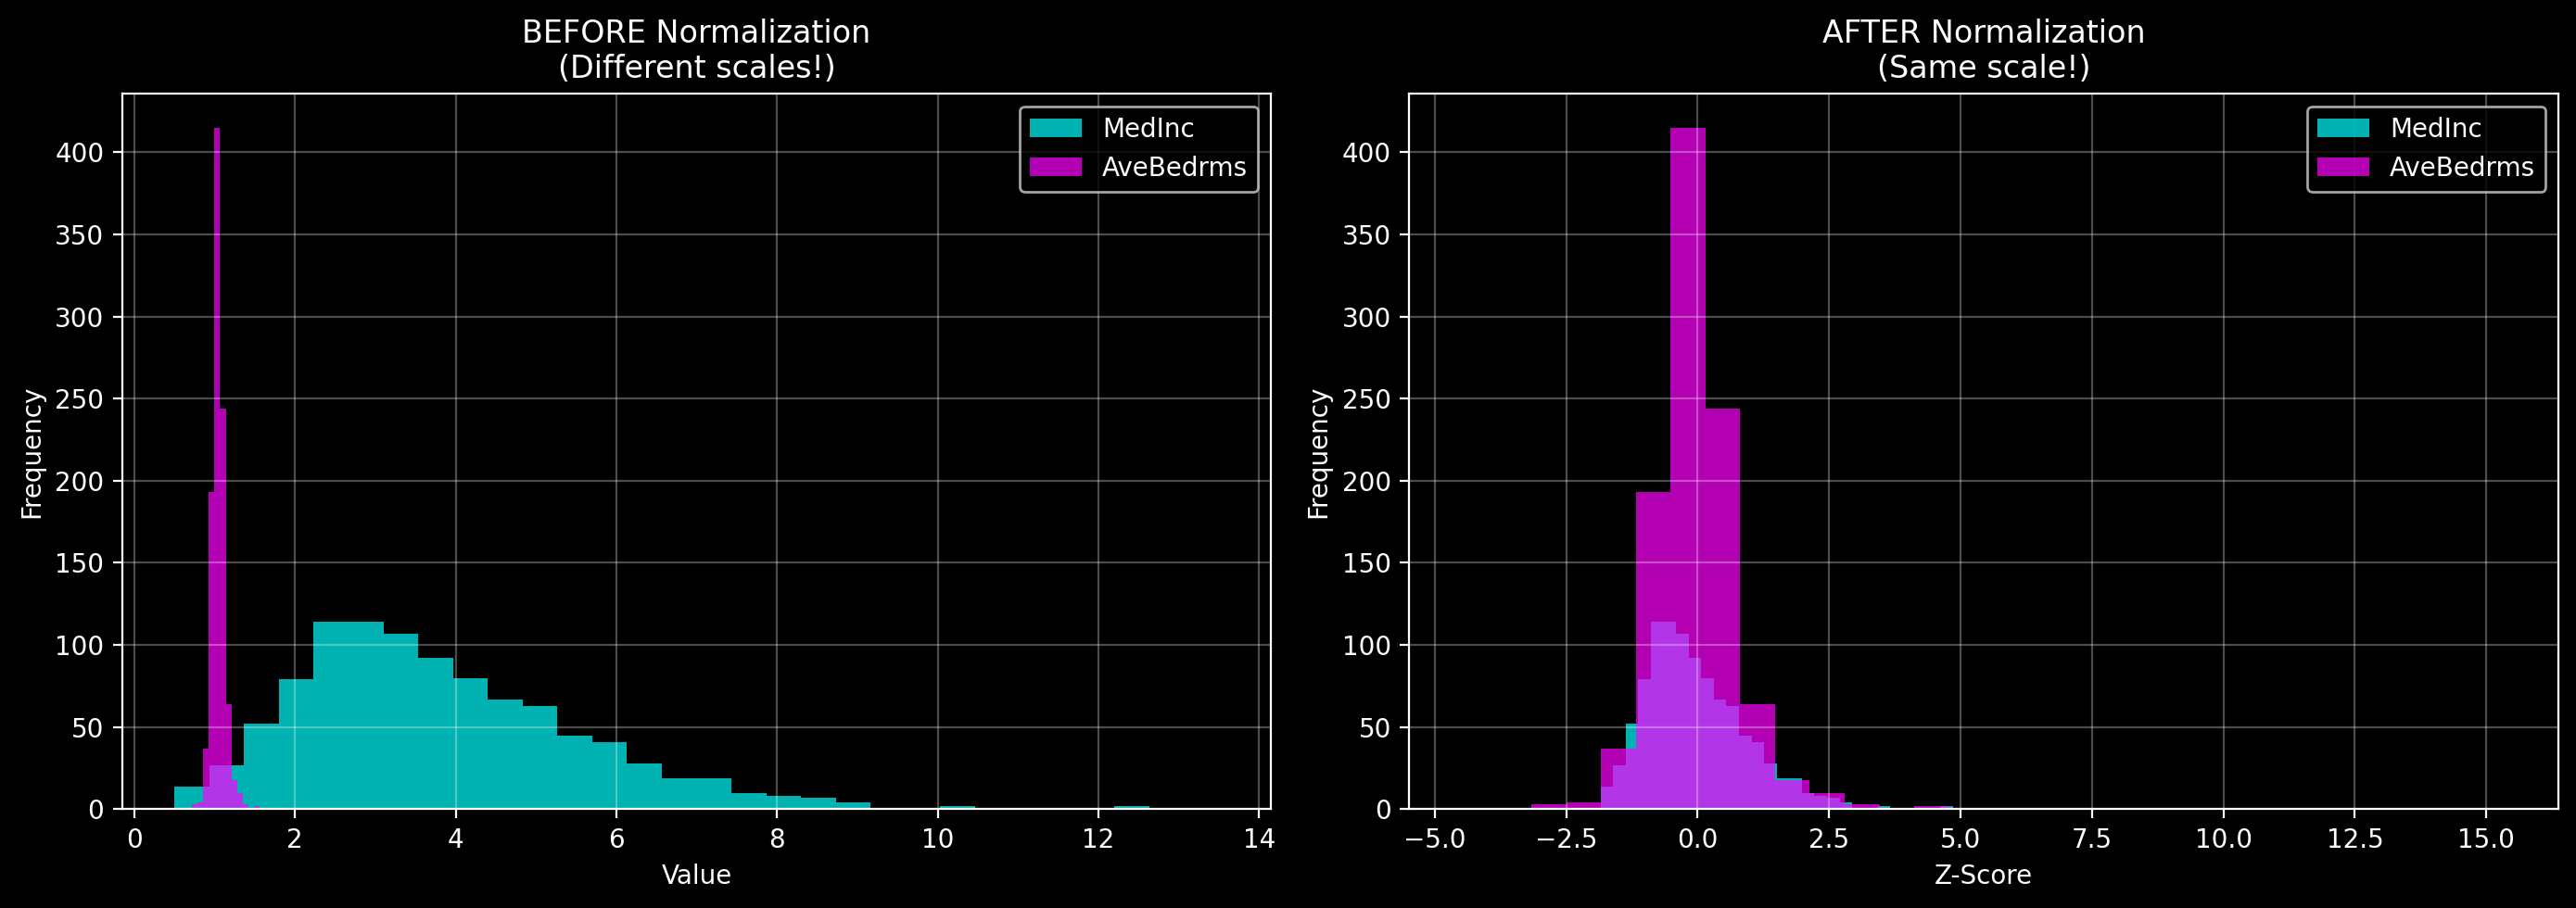

In [8]:
# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# Unnormalized
axes[0].hist(X_unnormalized[:, 0], bins=30, alpha=0.7, label='MedInc', color='cyan')
axes[0].hist(X_unnormalized[:, 1], bins=30, alpha=0.7, label='AveBedrms', color='magenta')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('BEFORE Normalization\n(Different scales!)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Normalized
axes[1].hist(X_normalized[:, 0], bins=30, alpha=0.7, label='MedInc', color='cyan')
axes[1].hist(X_normalized[:, 1], bins=30, alpha=0.7, label='AveBedrms', color='magenta')
axes[1].set_xlabel('Z-Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('AFTER Normalization\n(Same scale!)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
# 3D Cost Surface Visualization
def compute_cost_surface(X, y, w0_range, w1_range, grid_size=30):
    """Compute cost surface for visualization"""
    w0_vals = np.linspace(w0_range[0], w0_range[1], grid_size)
    w1_vals = np.linspace(w1_range[0], w1_range[1], grid_size)

    W0, W1 = np.meshgrid(w0_vals, w1_vals)
    costs = np.zeros_like(W0)

    for i in range(grid_size):
        for j in range(grid_size):
            weights = np.array([W0[i, j], W1[i, j]])
            y_pred = X @ weights
            costs[i, j] = np.mean((y_pred - y) ** 2)

    return W0, W1, costs


# Unnormalized cost surface
W0_u, W1_u, costs_u = compute_cost_surface(
    X_unnormalized, y_housing,
    w0_range=[-15, 15],
    w1_range=[-15, 15],
    grid_size=40
)

# Normalized cost surface
W0_n, W1_n, costs_n = compute_cost_surface(
    X_normalized, y_housing,
    w0_range=[-2, 2],
    w1_range=[-2, 2],
    grid_size=40
)

print("Surfaces computed")


Surfaces computed


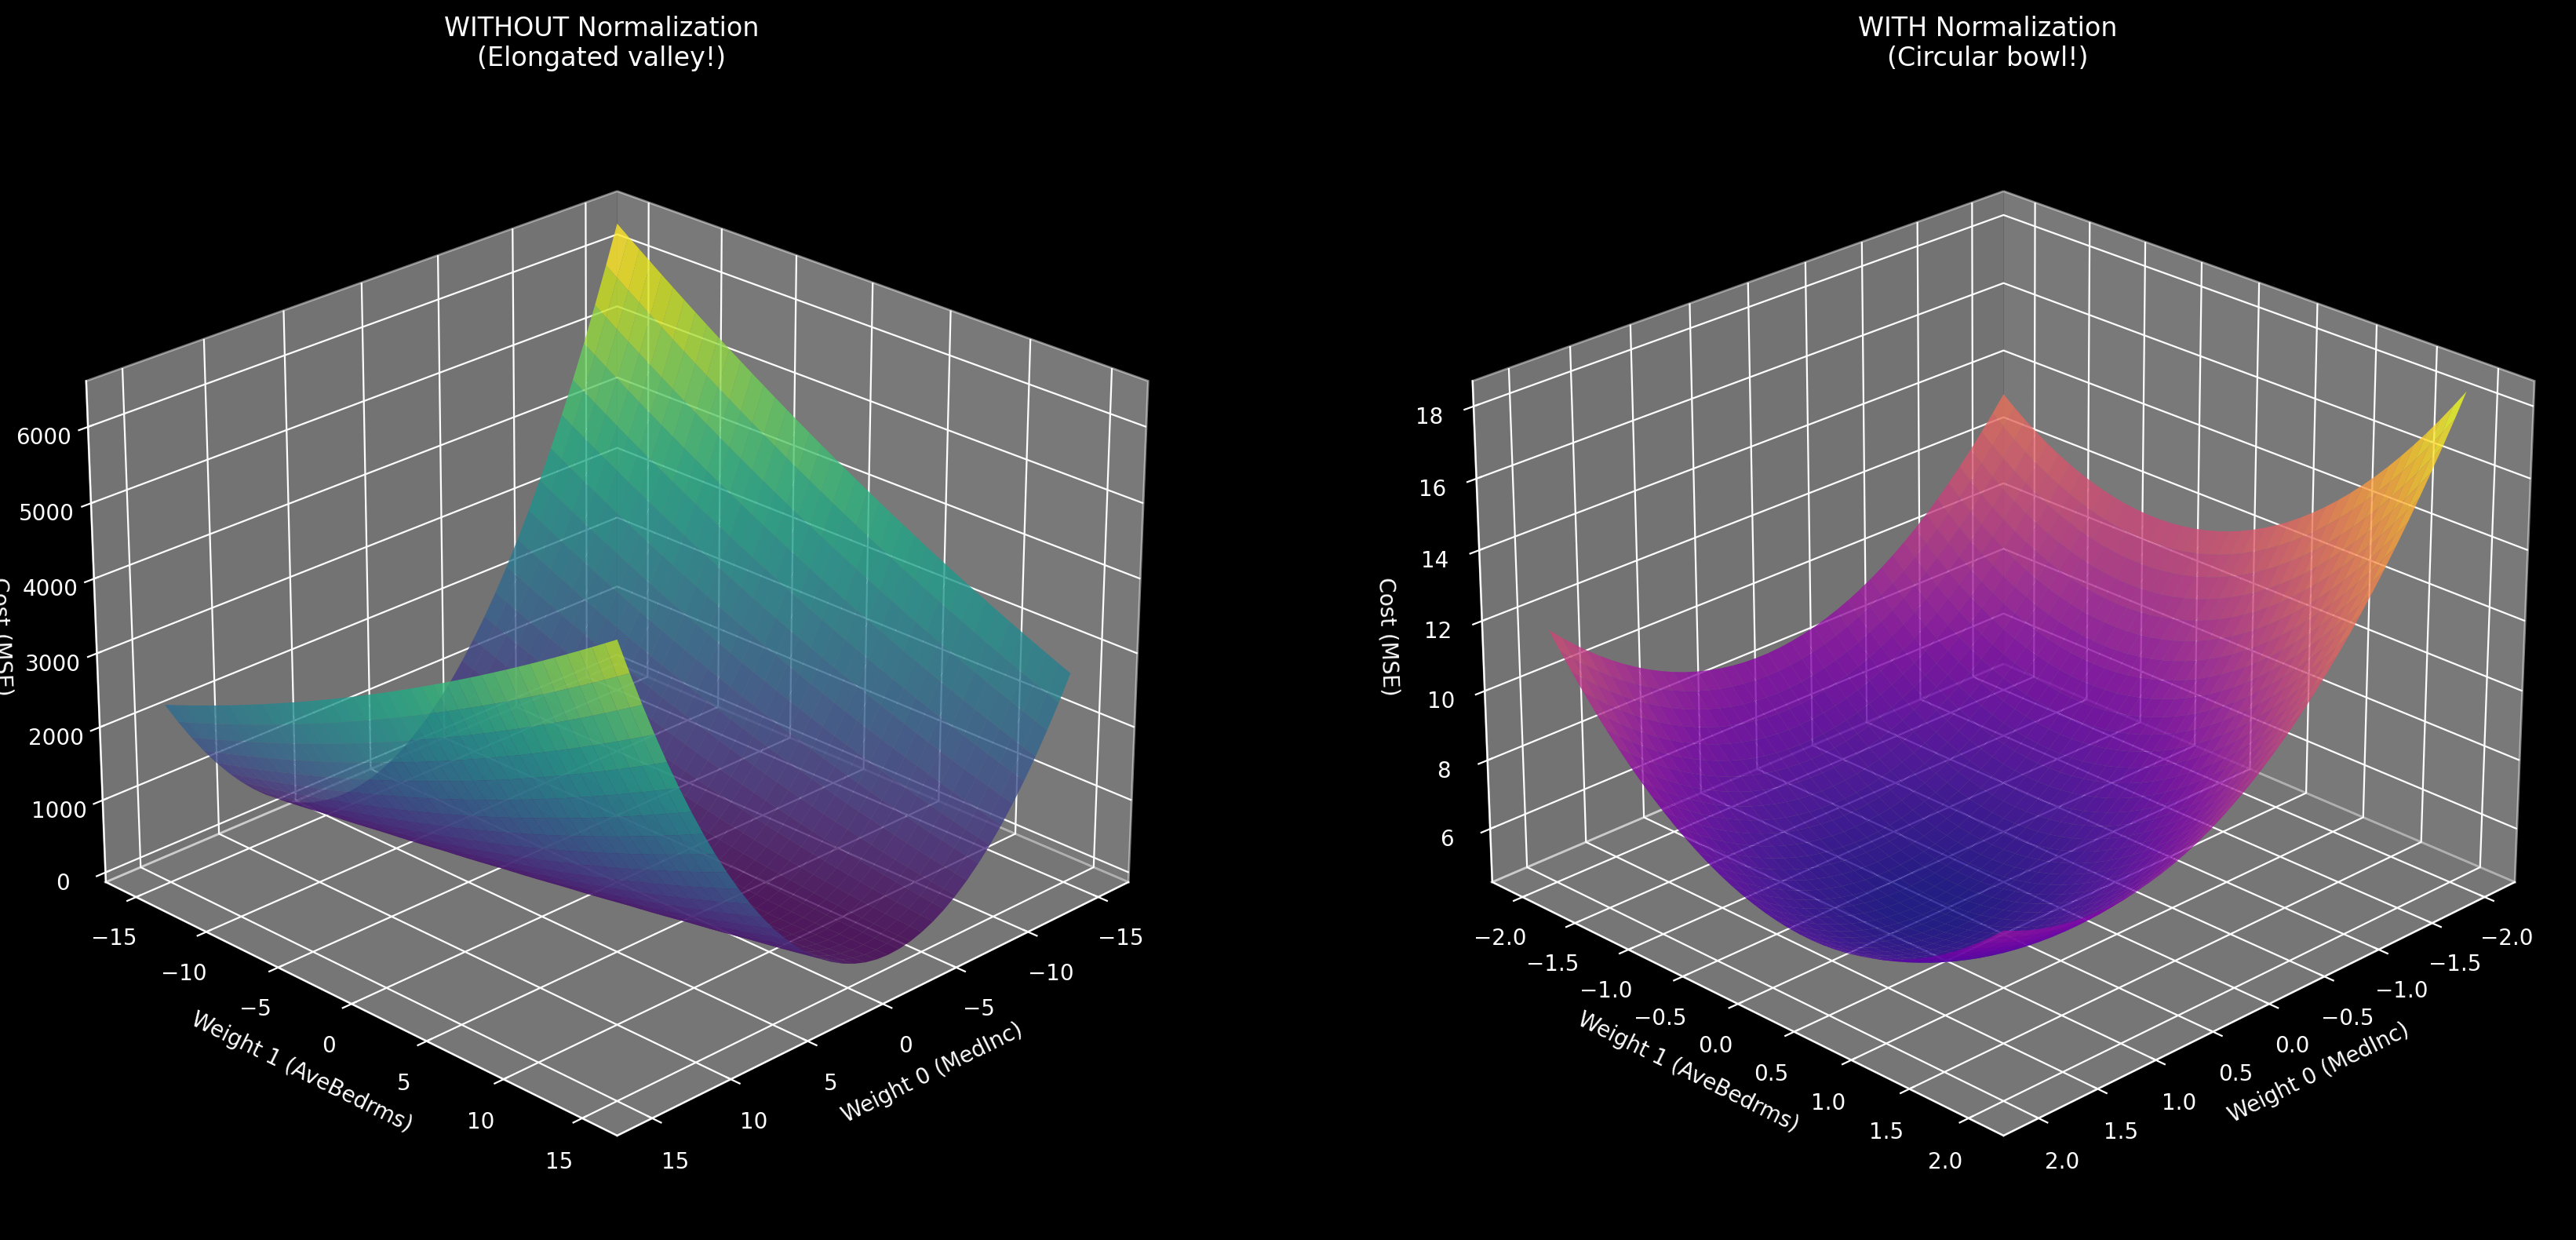

In [10]:
# Plot 3D surfaces
fig = plt.figure(figsize=(18, 8), dpi=200)

# Unnormalized
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(W0_u, W1_u, costs_u, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Weight 0 (MedInc)', fontsize=10)
ax1.set_ylabel('Weight 1 (AveBedrms)', fontsize=10)
ax1.set_zlabel('Cost (MSE)', fontsize=10)
ax1.set_title('WITHOUT Normalization\n(Elongated valley!)', fontsize=12)
ax1.view_init(elev=25, azim=45)

# Normalized
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(W0_n, W1_n, costs_n, cmap='plasma', alpha=0.8)
ax2.set_xlabel('Weight 0 (MedInc)', fontsize=10)
ax2.set_ylabel('Weight 1 (AveBedrms)', fontsize=10)
ax2.set_zlabel('Cost (MSE)', fontsize=10)
ax2.set_title('WITH Normalization\n(Circular bowl!)', fontsize=12)
ax2.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()


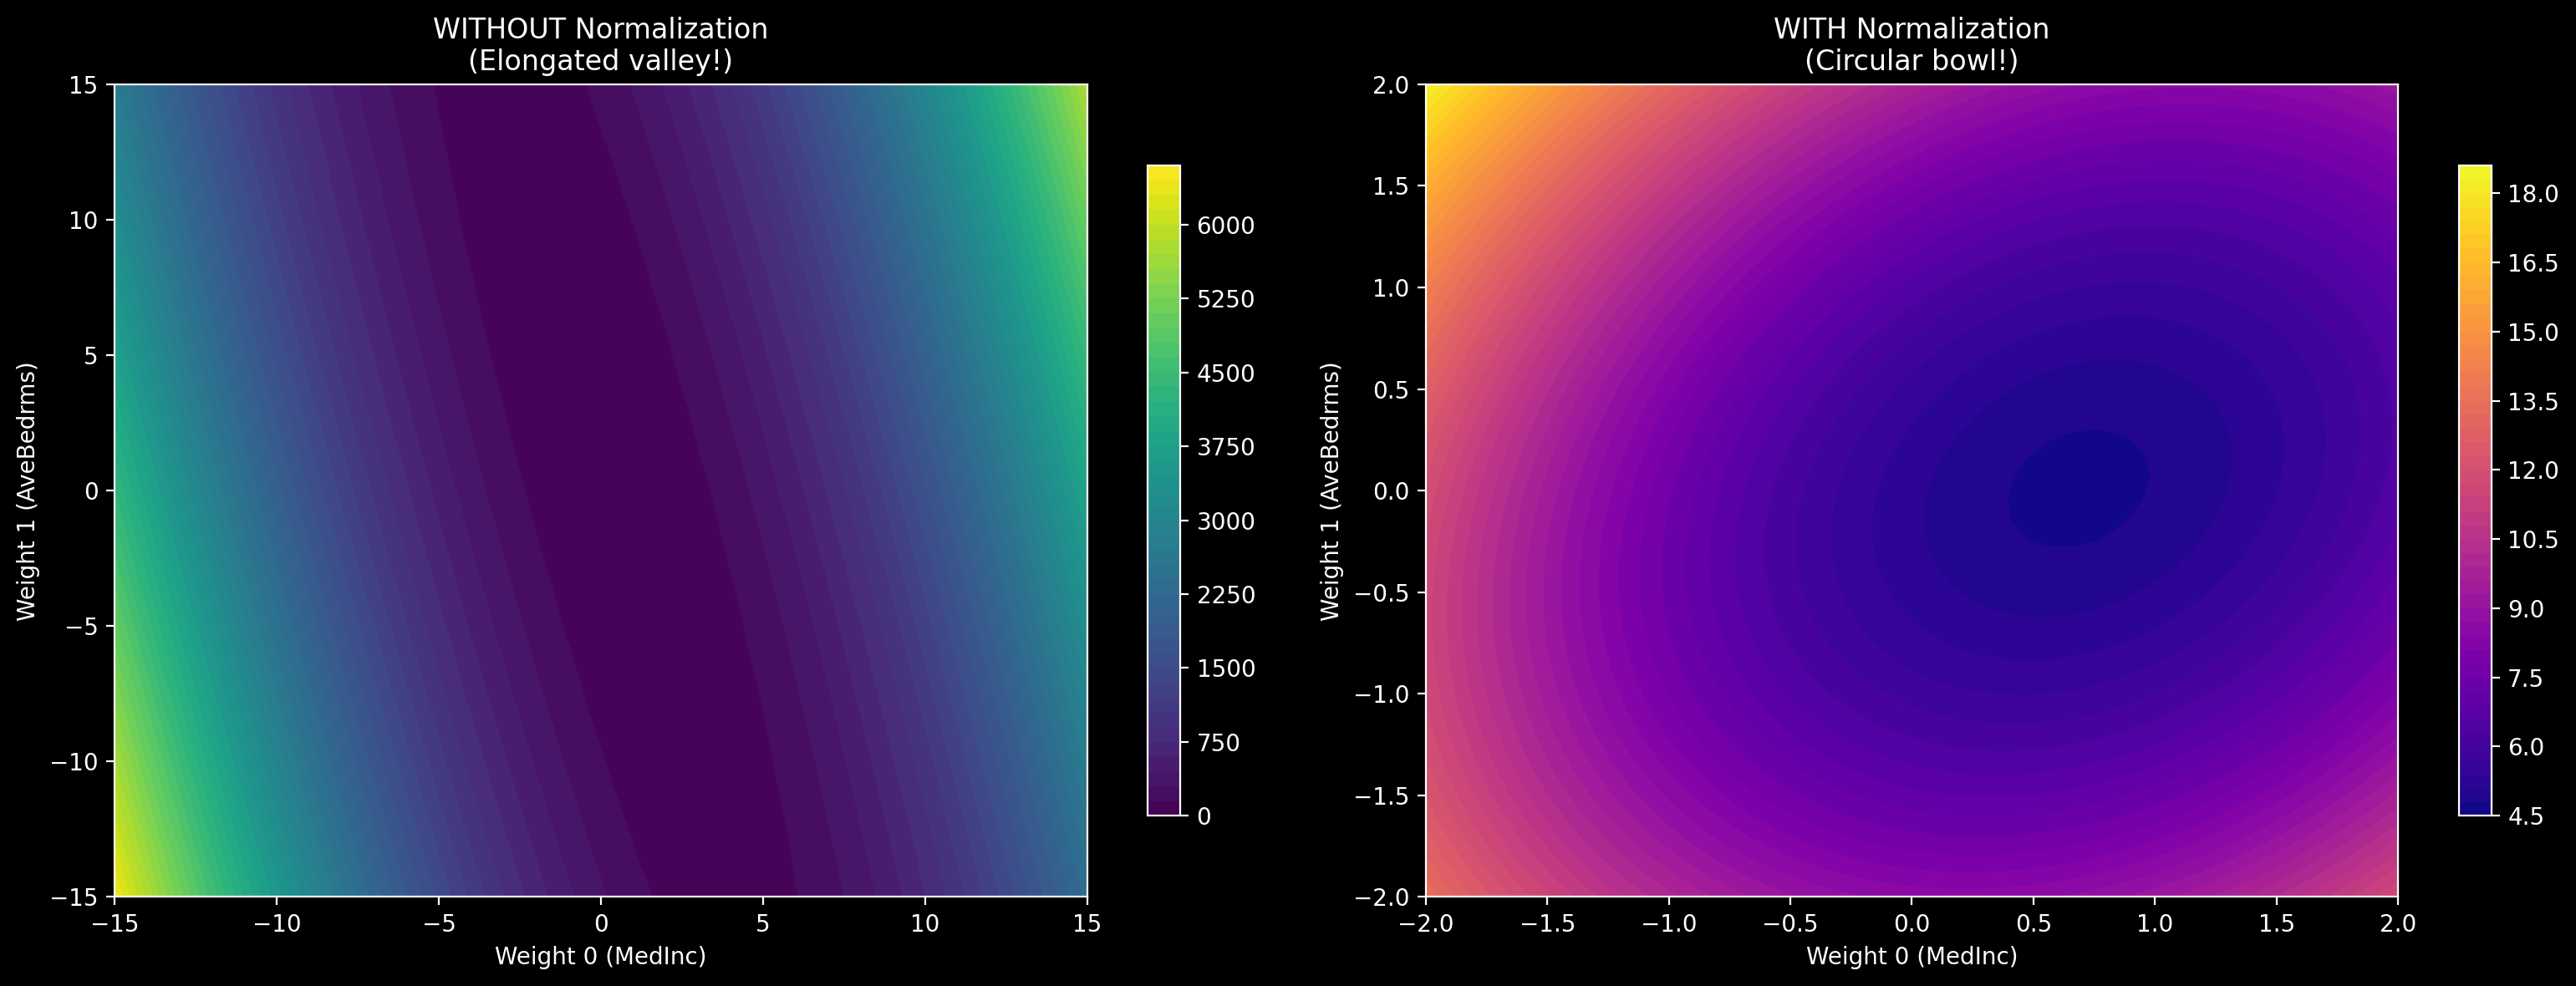

In [11]:
# Plot 2D contour/heatmap views
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=200)

# Unnormalized
c1 = axes[0].contourf(W0_u, W1_u, costs_u, levels=50, cmap='viridis')
axes[0].set_xlabel('Weight 0 (MedInc)', fontsize=10)
axes[0].set_ylabel('Weight 1 (AveBedrms)', fontsize=10)
axes[0].set_title('WITHOUT Normalization\n(Elongated valley!)', fontsize=12)
fig.colorbar(c1, ax=axes[0], shrink=0.8)

# Normalized
c2 = axes[1].contourf(W0_n, W1_n, costs_n, levels=50, cmap='plasma')
axes[1].set_xlabel('Weight 0 (MedInc)', fontsize=10)
axes[1].set_ylabel('Weight 1 (AveBedrms)', fontsize=10)
axes[1].set_title('WITH Normalization\n(Circular bowl!)', fontsize=12)
fig.colorbar(c2, ax=axes[1], shrink=0.8)

plt.tight_layout()
plt.show()


Feature 1 range: 0.05522117123602399 to 9.868869366005173
Feature 2 range: 55.61704424952563 to 7885.203632884805
Feature scales differ by factor of ~100

Training WITHOUT z-score normalization...
Final coefficients (unscaled): [1432099.89937627  152581.92688271]
Final intercept (unscaled): 3990713.04
Final cost (unscaled): 509068883434547456.00

Training WITH z-score normalization...
After scaling:
Feature 1 range: -1.5698020611168197 to 1.7456394894684528
Feature 2 range: -1.6831580128456487 to 1.6726627428842387

Final coefficients (scaled): [   7.21439774 1171.1662866 ]
Final intercept (scaled): 2018.11
Final cost (scaled): 378.81

Creating visualizations...



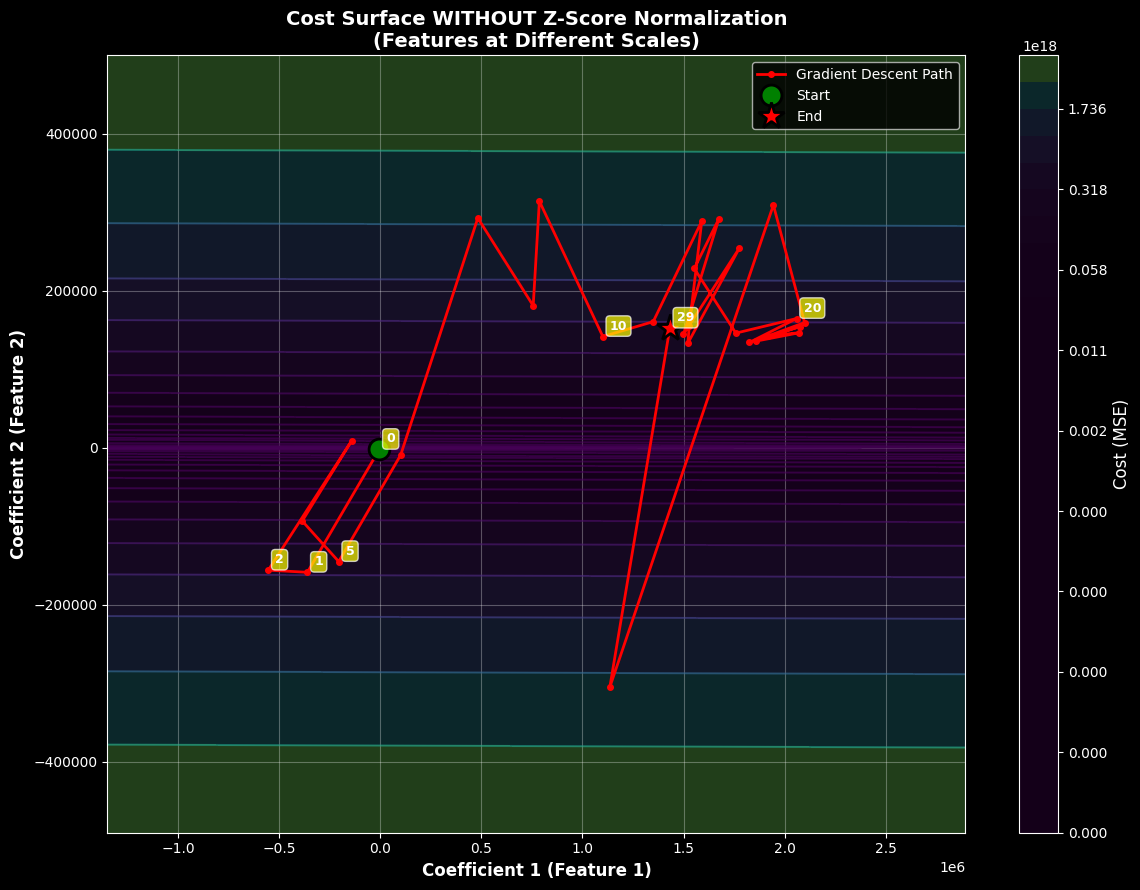

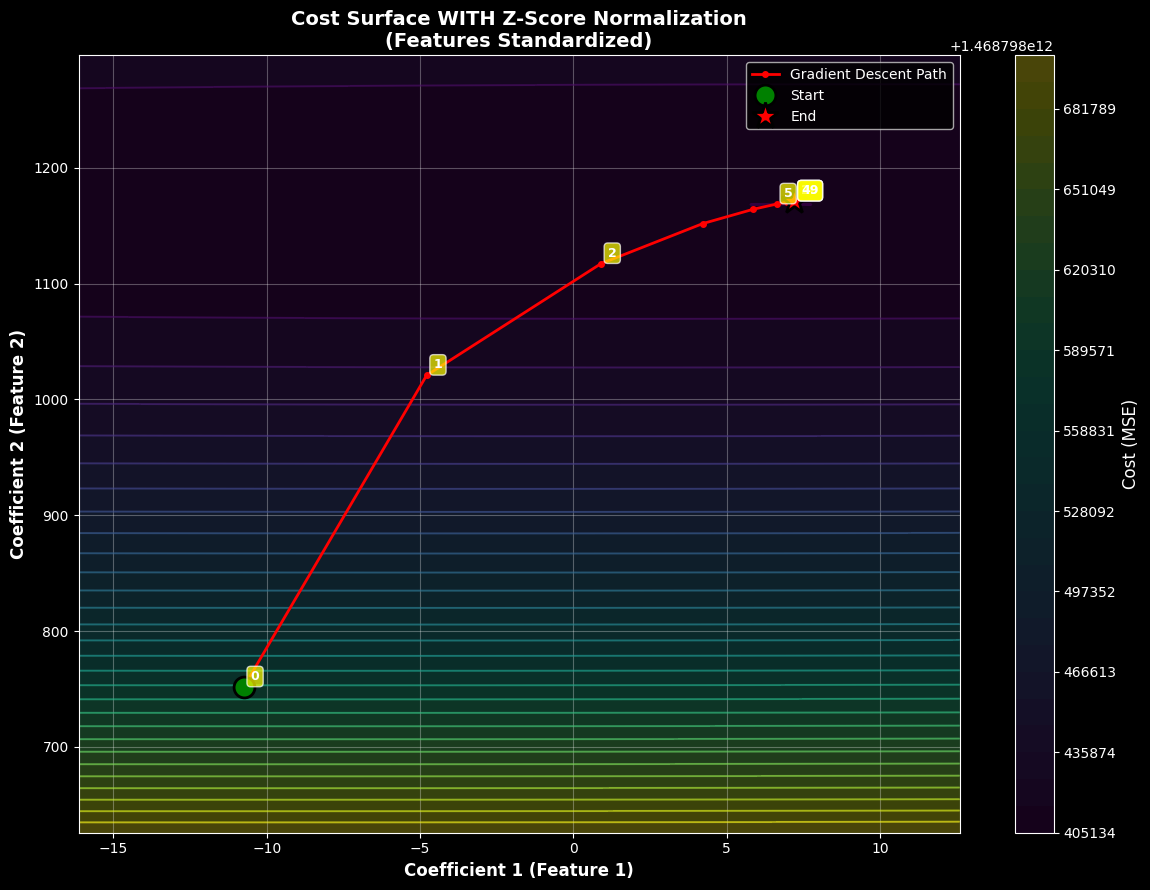

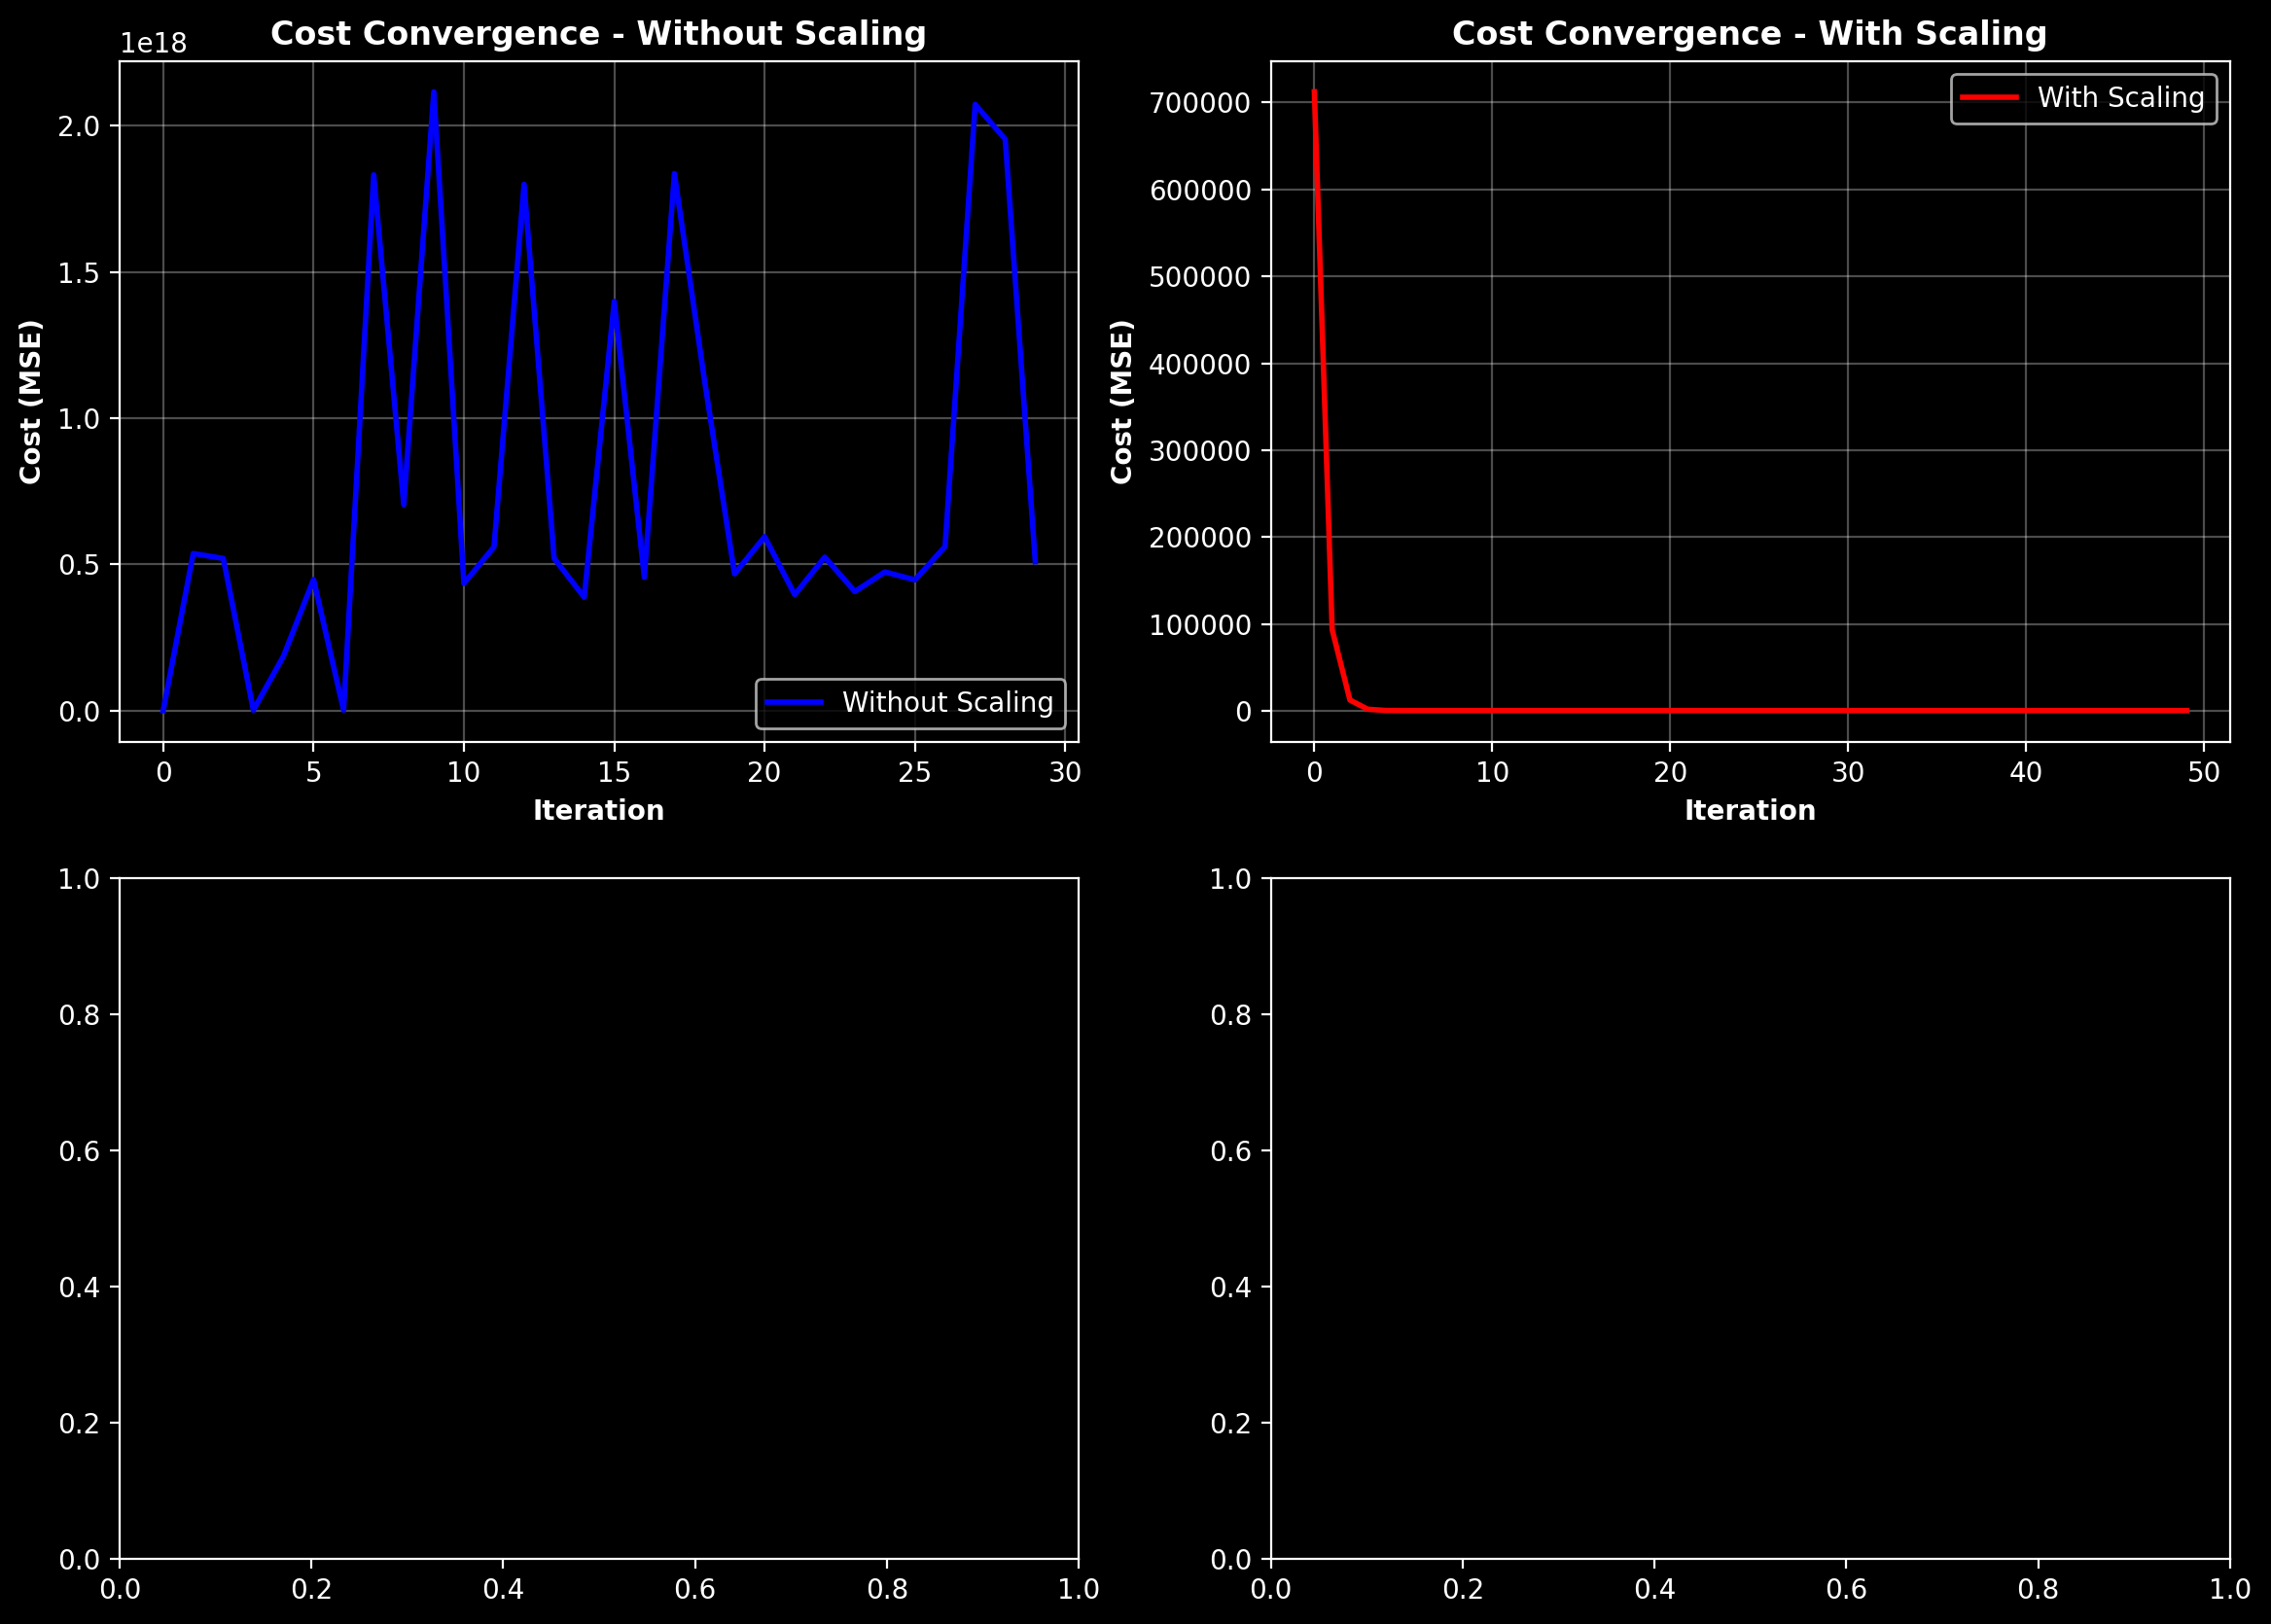

In [12]:
# This visualisation is more about the concept rather than to know all the details of the code so keep that in mind
# and don't worry if not all parts of this code are clear
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with two features at different scales
n_samples = 100

# Feature 1: small scale (0-10)
X1 = np.random.uniform(0, 10, n_samples)

# Feature 2: large scale
X2 = np.random.uniform(0, 8000, n_samples)

# True coefficients
true_coef = np.array([3.0, 0.5])
true_intercept = 10.0

# Generate target with some noise
y = true_intercept + true_coef[0] * X1 + true_coef[1] * X2 + np.random.normal(0, 20, n_samples)

# Combine features
X = np.column_stack([X1, X2])

print("Feature 1 range:", X1.min(), "to", X1.max())
print("Feature 2 range:", X2.min(), "to", X2.max())
print("Feature scales differ by factor of ~100")
print()

# Function to manually compute cost (MSE) for given coefficients
def compute_cost(X, y, coef, intercept):
    predictions = intercept + X @ coef
    mse = np.mean((y - predictions) ** 2)
    return mse

# Function to track gradient descent steps
class SGDWithHistory(SGDRegressor):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.coef_history = []
        self.intercept_history = []
        self.cost_history = []

    def partial_fit(self, X, y):
        super().partial_fit(X, y)
        self.coef_history.append(self.coef_.copy())
        self.intercept_history.append(self.intercept_.copy())
        cost = compute_cost(X, y, self.coef_, self.intercept_[0])
        self.cost_history.append(cost)
        return self

# Train WITHOUT scaling
print("Training WITHOUT z-score normalization...")
model_unscaled = SGDWithHistory(
    learning_rate='constant',
    eta0=0.0000001,  # Very small learning rate needed for unscaled data
    # because otherwise the feature with high scaling will cause paths to vary a lot and not appear
    max_iter=1,
    tol=None,
    random_state=42
)

# Initialize and train step by step
for i in range(30):
    model_unscaled.partial_fit(X, y)

print(f"Final coefficients (unscaled): {model_unscaled.coef_}")
print(f"Final intercept (unscaled): {model_unscaled.intercept_[0]:.2f}")
print(f"Final cost (unscaled): {model_unscaled.cost_history[-1]:.2f}")
print()

# Train WITH scaling
print("Training WITH z-score normalization...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("After scaling:")
print("Feature 1 range:", X_scaled[:, 0].min(), "to", X_scaled[:, 0].max())
print("Feature 2 range:", X_scaled[:, 1].min(), "to", X_scaled[:, 1].max())
print()

model_scaled = SGDWithHistory(
    learning_rate='constant',
    eta0=0.01,  # Can use much larger learning rate with scaled data
    max_iter=1,
    tol=None,
    random_state=42
)

# Initialize and train step by step
for i in range(50):
    model_scaled.partial_fit(X_scaled, y)

print(f"Final coefficients (scaled): {model_scaled.coef_}")
print(f"Final intercept (scaled): {model_scaled.intercept_[0]:.2f}")
print(f"Final cost (scaled): {model_scaled.cost_history[-1]:.2f}")
print()

# Create cost surface visualizations
def create_cost_surface(X, y, coef_history, title):
    """Create 2D cost surface contour plot with gradient descent path"""

    # Get the final coefficients as center point
    final_coef = coef_history[-1]

    # Create grid around the path
    coef_history_array = np.array(coef_history)
    coef1_range = coef_history_array[:, 0]
    coef2_range = coef_history_array[:, 1]

    # Extend range for better visualization
    coef1_min, coef1_max = coef1_range.min(), coef1_range.max()
    coef2_min, coef2_max = coef2_range.min(), coef2_range.max()

    coef1_range_plot = np.linspace(coef1_min - abs(coef1_max - coef1_min) * 0.3,
                                    coef1_max + abs(coef1_max - coef1_min) * 0.3, 100)
    coef2_range_plot = np.linspace(coef2_min - abs(coef2_max - coef2_min) * 0.3,
                                    coef2_max + abs(coef2_max - coef2_min) * 0.3, 100)

    # Create meshgrid
    C1, C2 = np.meshgrid(coef1_range_plot, coef2_range_plot)

    # Compute cost for each point on the grid
    Z = np.zeros_like(C1)
    for i in range(C1.shape[0]):
        for j in range(C1.shape[1]):
            coef = np.array([C1[i, j], C2[i, j]])
            # Use mean intercept from history
            intercept = np.mean([h[0] for h in model_scaled.intercept_history]) if 'Normalized' in title else np.mean([h[0] for h in model_unscaled.intercept_history])
            Z[i, j] = compute_cost(X, y, coef, intercept)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 9))

    # Plot contours - handle edge cases
    z_min, z_max = Z.min(), Z.max()
    z_range = z_max - z_min

    # If the range is very small or zero, use linear spacing
    if z_range < 1e-10 or not np.isfinite(z_range):
        levels = np.linspace(z_min, z_max, 30)
    else:
        # Use log spacing for better visualization if range is reasonable
        if z_min <= 0:
            levels = np.linspace(z_min, z_max, 30)
        else:
            try:
                levels = np.logspace(np.log10(z_min + 1), np.log10(z_max + 1), 30)
            except:
                levels = np.linspace(z_min, z_max, 30)

    # Remove duplicates and ensure increasing
    levels = np.unique(levels)

    contour = ax.contour(C1, C2, Z, levels=levels, cmap='viridis', alpha=0.6)
    contourf = ax.contourf(C1, C2, Z, levels=levels, cmap='viridis', alpha=0.3)

    cbar = plt.colorbar(contourf, ax=ax)
    cbar.set_label('Cost (MSE)', fontsize=12)

    coef_history_array = np.array(coef_history)
    ax.plot(coef_history_array[:, 0], coef_history_array[:, 1],
            'r.-', linewidth=2, markersize=8, label='Gradient Descent Path')

    ax.plot(coef_history_array[0, 0], coef_history_array[0, 1],
            'go', markersize=15, label='Start', markeredgecolor='black', markeredgewidth=2)
    ax.plot(coef_history_array[-1, 0], coef_history_array[-1, 1],
            'r*', markersize=20, label='End', markeredgecolor='black', markeredgewidth=2)

    # Add step numbers for first few steps
    for i in [0, 1, 2, 5, 10, 20, len(coef_history_array)-1]:
        if i < len(coef_history_array):
            ax.annotate(f'{i}',
                       xy=(coef_history_array[i, 0], coef_history_array[i, 1]),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=9, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

    ax.set_xlabel('Coefficient 1 (Feature 1)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Coefficient 2 (Feature 2)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

    return fig

print("Creating visualizations...")
print()
fig1 = create_cost_surface(X, y, model_unscaled.coef_history,
                           'Cost Surface WITHOUT Z-Score Normalization\n(Features at Different Scales)')

fig2 = create_cost_surface(X_scaled, y, model_scaled.coef_history,
                           'Cost Surface WITH Z-Score Normalization\n(Features Standardized)')

fig3, axes = plt.subplots(2, 2, figsize=(14, 10), dpi = 200)

axes[0, 0].plot(model_unscaled.cost_history, 'b-', linewidth=2, label='Without Scaling')
axes[0, 0].set_xlabel('Iteration', fontweight='bold')
axes[0, 0].set_ylabel('Cost (MSE)', fontweight='bold')
axes[0, 0].set_title('Cost Convergence - Without Scaling', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].plot(model_scaled.cost_history, 'r-', linewidth=2, label='With Scaling')
axes[0, 1].set_xlabel('Iteration', fontweight='bold')
axes[0, 1].set_ylabel('Cost (MSE)', fontweight='bold')
axes[0, 1].set_title('Cost Convergence - With Scaling', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()


### Exercise 1: Normalize Train & Test Sets

**Task:** Normalize both training and test sets using training statistics only.


In [13]:
# Load diabetes dataset and split
diabetes = load_diabetes()
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    diabetes.data, diabetes.target, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (353, 10)
Test shape: (89, 10)


In [15]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

print(f"Train mean: {X_train_norm.mean():.8f}")
print(f"Test mean: {X_test_norm.mean():.8f}")

Train mean: 0.00000000
Test mean: -0.05910589


In [16]:
print("Exercise 1 passed!")


Exercise 1 passed!


---
# 2. Outlier Detection & Handling

**Problem:** Extreme values distort statistics and hurt model performance

**Methods:**
1. **IQR Detection:** $Q_1 - 1.5 \times IQR$ to $Q_3 + 1.5 \times IQR$
2. **Percentile Capping:** Clip at 5th/95th percentile


In [17]:
# Get median income from California Housing
med_income = X_housing[:, 0].copy()

print("--- Original Data Statistics ---")
print(f"Mean: {med_income.mean():.2f}")
print(f"Std:  {med_income.std():.2f}")
print(f"Max:  {med_income.max():.2f}")


--- Original Data Statistics ---
Mean: 3.84
Std:  1.81
Max:  13.50


In [18]:
# Add artificial outliers
np.random.seed(42)
outlier_indices = np.random.choice(len(med_income), size=30, replace=False)
med_income_with_outliers = med_income.copy()
med_income_with_outliers[outlier_indices] = np.random.uniform(15, 25, size=30)

print("\n--- After Adding 30 Outliers ---")
print(f"Mean: {med_income_with_outliers.mean():.2f} (shifted!)")
print(f"Std:  {med_income_with_outliers.std():.2f} (inflated!)")
print(f"Max:  {med_income_with_outliers.max():.2f}")



--- After Adding 30 Outliers ---
Mean: 4.33 (shifted!)
Std:  3.39 (inflated!)
Max:  24.90


In [19]:
# IQR outlier detection
Q1 = np.percentile(med_income_with_outliers, 25)
Q3 = np.percentile(med_income_with_outliers, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (med_income_with_outliers < lower_bound) | (med_income_with_outliers > upper_bound)

print(f"\n--- IQR Outlier Detection ---")
print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"Outliers detected: {outlier_mask.sum()}")



--- IQR Outlier Detection ---
Q1: 2.57, Q3: 5.04, IQR: 2.47
Lower bound: -1.14
Upper bound: 8.75
Outliers detected: 42


In [20]:
# Cap at 95th percentile
cap_value = np.percentile(med_income_with_outliers, 95)
med_income_capped = np.clip(med_income_with_outliers, None, cap_value)

print(f"\n--- After Capping at 95th Percentile ---")
print(f"Cap value: {cap_value:.2f}")
print(f"Mean: {med_income_capped.mean():.2f} (closer to original!)")
print(f"Std:  {med_income_capped.std():.2f}")
print(f"Max:  {med_income_capped.max():.2f}")



--- After Capping at 95th Percentile ---
Cap value: 8.21
Mean: 3.93 (closer to original!)
Std:  1.83
Max:  8.21


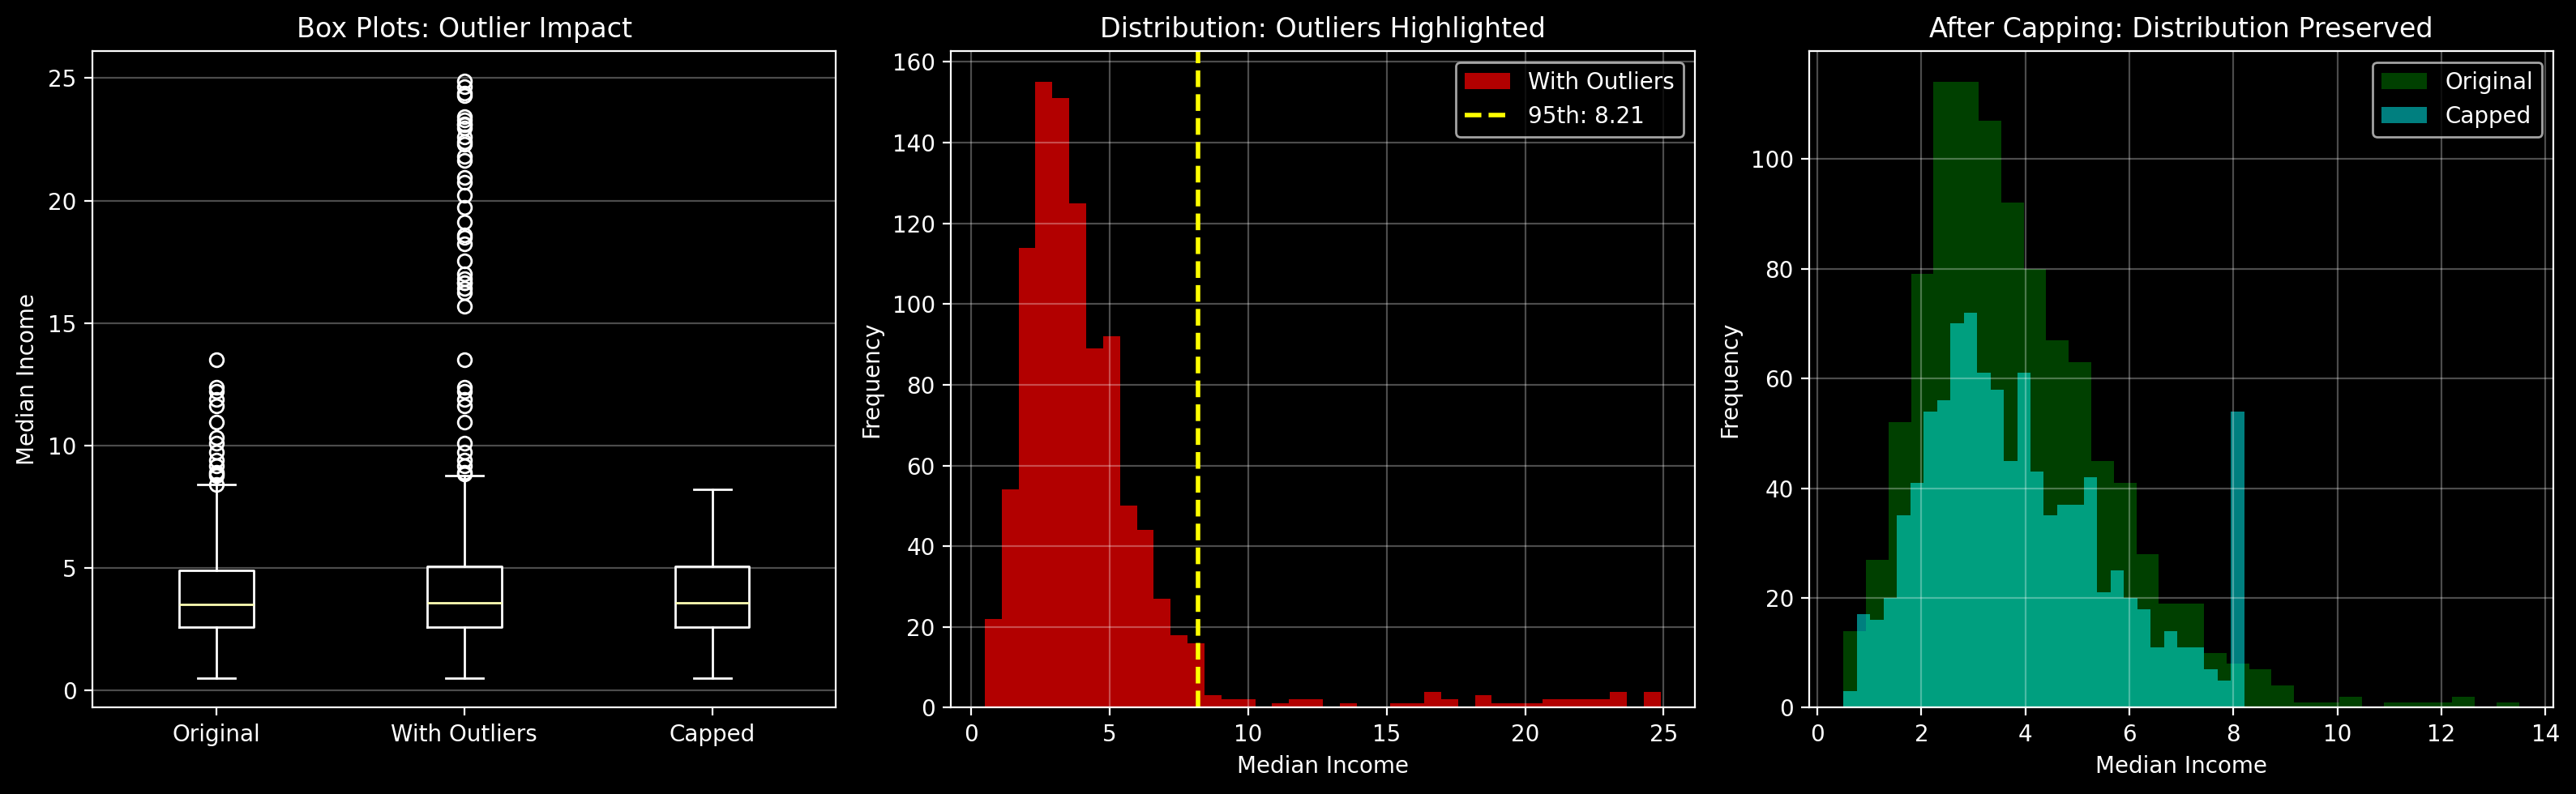

In [21]:
# Visualize outliers
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=200)

# Box plots
bp_data = [med_income, med_income_with_outliers, med_income_capped]
bp = axes[0].boxplot(bp_data, tick_labels=['Original', 'With Outliers', 'Capped'])
axes[0].set_ylabel('Median Income')
axes[0].set_title('Box Plots: Outlier Impact')
axes[0].grid(alpha=0.3, axis='y')

# Histograms
axes[1].hist(med_income_with_outliers, bins=40, alpha=0.7, color='red', label='With Outliers')
axes[1].axvline(cap_value, color='yellow', linestyle='--', linewidth=2, label=f'95th: {cap_value:.2f}')
axes[1].set_xlabel('Median Income')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution: Outliers Highlighted')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Comparison
axes[2].hist(med_income, bins=30, alpha=0.5, color='green', label='Original')
axes[2].hist(med_income_capped, bins=30, alpha=0.5, color='cyan', label='Capped')
axes[2].set_xlabel('Median Income')
axes[2].set_ylabel('Frequency')
axes[2].set_title('After Capping: Distribution Preserved')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [22]:
# Impact on model training
# Create full feature matrices
X_with_outliers = X_housing[:, :4].copy()
X_with_outliers[:, 0] = med_income_with_outliers

X_capped_full = X_housing[:, :4].copy()
X_capped_full[:, 0] = med_income_capped

# NORMALIZE before training (important!) ... ALSO note that the order of steps is very important, zsocring relies on the mean of data and if the mean
# is estimated with outliers this will affect its estimation
X_with_outliers = StandardScaler().fit_transform(X_with_outliers)
X_capped_full = StandardScaler().fit_transform(X_capped_full)

# Train both models
_, _, cost_outliers, _ = gradient_descent_regression(X_with_outliers, y_housing, 0.01, 500)
_, _, cost_capped, _ = gradient_descent_regression(X_capped_full, y_housing, 0.01, 500)

print("\n--- Model Training Results ---")
print(f"Final cost WITH outliers: {cost_outliers[-1]:.4f}")
print(f"Final cost AFTER capping: {cost_capped[-1]:.4f}")
print(f"Improvement: {((cost_outliers[-1] - cost_capped[-1]) / cost_outliers[-1] * 100):.1f}%")



--- Model Training Results ---
Final cost WITH outliers: 0.2343
Final cost AFTER capping: 0.1997
Improvement: 14.8%


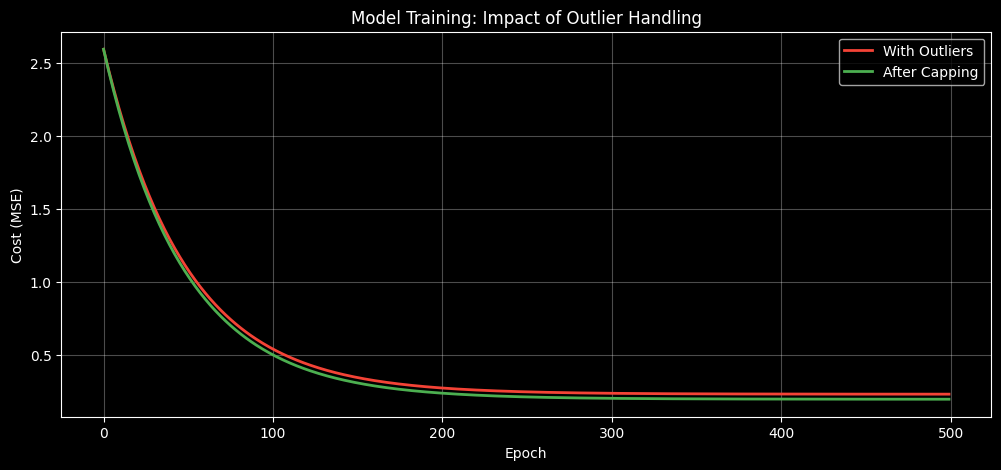

In [23]:
# Plot training curves ... this depends on the data and in many cases the differences will be huge
plt.figure(figsize=(12, 5))
plt.plot(cost_outliers, label='With Outliers', color='#f44336', linewidth=2)
plt.plot(cost_capped, label='After Capping', color='#4CAF50', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Cost (MSE)')
plt.title('Model Training: Impact of Outlier Handling')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Exercise 2: Cap Outliers at 95th Percentile


In [24]:
# Create test data with outliers
np.random.seed(123)
test_data = np.random.randn(200) * 10 + 50
test_data[:10] = 150  # Add outliers

print(f"Before capping:")
print(f"  Max: {test_data.max():.2f}")
print(f"  Mean: {test_data.mean():.2f}")


Before capping:
  Max: 150.00
  Mean: 55.17


In [26]:
cap_value_95 = np.percentile(test_data, 95)
capped_data = np.clip(test_data, None, cap_value_95)

print(f"\nAfter capping:")
print(f"  Max: {capped_data.max():.2f}")
print(f"  Mean: {capped_data.mean():.2f}")


After capping:
  Max: 79.68
  Mean: 51.66


In [27]:
print("Exercise 2 passed!")


Exercise 2 passed!


---
# 3. Missing Value Imputation

**Problem:** NaN values break model training

**Strategies:**
1. **Mean Imputation:** Fill with column mean
2. **Median Imputation:** Fill with column median (robust to outliers)
3. **KNN Imputation:** Fill based on k nearest neighbors


In [28]:
# Create dataset with missing values
diabetes = load_diabetes()
X_diabetes = diabetes.data[:500].copy()
y_diabetes = diabetes.target[:500].copy()

# Introduce missing values
np.random.seed(42)
n_samples, n_features = X_diabetes.shape
n_missing = int(0.15 * n_samples * n_features) # 15% of the whole elements will be missing

missing_indices = np.random.choice(n_samples * n_features, size=n_missing, replace=False)
rows = missing_indices // n_features
cols = missing_indices % n_features
X_diabetes[rows, cols] = np.nan

print(f"--- Dataset with Missing Values ---")
print(f"Total values: {n_samples * n_features}")
print(f"Missing values: {np.isnan(X_diabetes).sum()}")
print(f"Missing percentage: {np.isnan(X_diabetes).sum() / (n_samples * n_features) * 100:.1f}%")
print(f"Rows with missing: {np.any(np.isnan(X_diabetes), axis=1).sum()}")


--- Dataset with Missing Values ---
Total values: 4420
Missing values: 663
Missing percentage: 15.0%
Rows with missing: 350


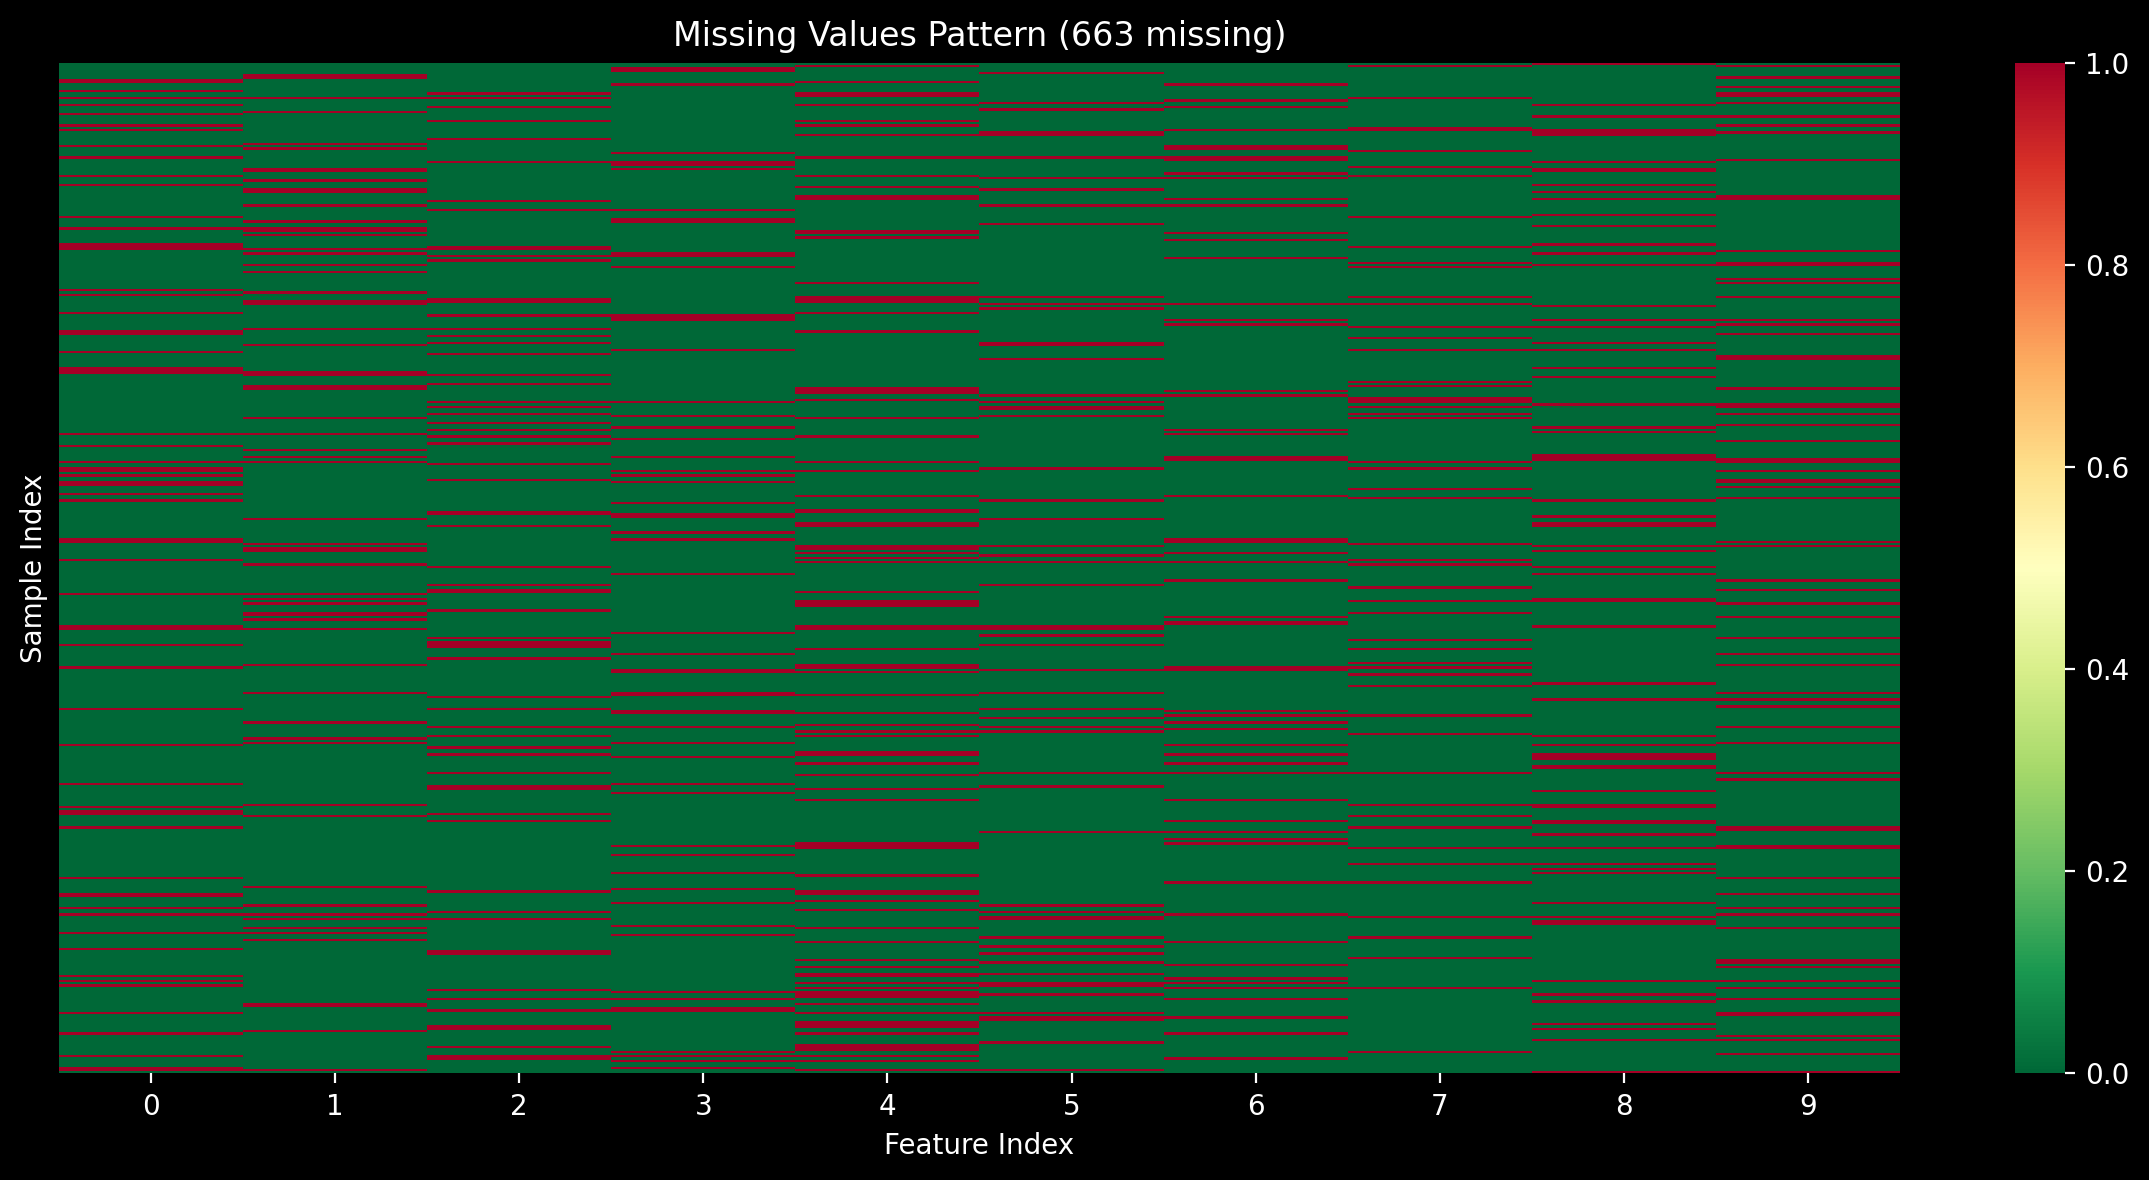

In [29]:
# Visualize missing pattern
plt.figure(figsize=(12, 6), dpi = 200)
sns.heatmap(np.isnan(X_diabetes), cbar=True, yticklabels=False, cmap='RdYlGn_r')
plt.xlabel('Feature Index')
plt.ylabel('Sample Index')
plt.title(f'Missing Values Pattern ({np.isnan(X_diabetes).sum()} missing)')
plt.tight_layout()
plt.show()


In [30]:
# Imputation Strategy 1: Mean
def mean_imputation(X):
    X_imp = X.copy()
    means = np.nanmean(X, axis=0)
    for col in range(X.shape[1]):
        mask = np.isnan(X_imp[:, col])
        X_imp[mask, col] = means[col]
    return X_imp, means

X_mean_imp, means = mean_imputation(X_diabetes)
print(f"Mean imputation: {np.isnan(X_mean_imp).sum()} missing remaining")


Mean imputation: 0 missing remaining


In [31]:
# Imputation Strategy 2: Median
def median_imputation(X):
    X_imp = X.copy()
    medians = np.nanmedian(X, axis=0)
    for col in range(X.shape[1]):
        mask = np.isnan(X_imp[:, col])
        X_imp[mask, col] = medians[col]
    return X_imp, medians

X_median_imp, medians = median_imputation(X_diabetes)
print(f"Median imputation: {np.isnan(X_median_imp).sum()} missing remaining")


Median imputation: 0 missing remaining


In [32]:
# Imputation Strategy 3: KNN .. uses Euclidean
knn_imputer = KNNImputer(n_neighbors=5)
X_knn_imp = knn_imputer.fit_transform(X_diabetes)

print(f"KNN imputation: {np.isnan(X_knn_imp).sum()} missing remaining")


KNN imputation: 0 missing remaining


### Exercise 3: Implement Median Imputation


In [33]:
# Create practice dataset
np.random.seed(456)
X_practice = diabetes.data[100:300].copy()

# Add 20% missing values
n_s, n_f = X_practice.shape
n_miss = int(0.20 * n_s * n_f)
idx = np.random.choice(n_s * n_f, size=n_miss, replace=False)
X_practice[idx // n_f, idx % n_f] = np.nan

print(f"Missing values: {np.isnan(X_practice).sum()}")


Missing values: 400


In [35]:
# YOUR TASK: Implement median imputation
# YOUR CODE HERE
knn_imputer_practice = KNNImputer(n_neighbors=5)
X_practice_imp = knn_imputer_practice.fit_transform(X_practice)

print(f"After imputation: {np.isnan(X_practice_imp).sum()} missing")

After imputation: 0 missing


In [36]:
print("Exercise 3 passed!")


Exercise 3 passed!


---
## Summary

✅ **Z-Score Normalization:**
- Prevents elongated cost surfaces
- Enables faster convergence with larger learning rates
- Use `StandardScaler` with train statistics only

✅ **Outlier Handling:**
- Detect with IQR method
- Cap at percentiles (5th/95th)
- Improves model performance

✅ **Missing Value Imputation:**
- Mean: Simple but affected by outliers
- Median: Robust to outliers
- KNN: Preserves relationships between features


✅ Apply Z-scoring after fixing outliers and missing values to get accurate mean estimation


